In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [2]:
data = pd.read_csv(r'events_log.csv')
data.timestamp = data.timestamp.apply(lambda x: datetime.datetime.utcfromtimestamp(int(x/1000)))

In [3]:
data['day'] = data.timestamp.apply(lambda x: pd.datetime.date(x).day)
data['month'] = data.timestamp.apply(lambda x: pd.datetime.date(x).month)

In [4]:
data.head(5)

,uuid,timestamp,session_id,group,action,checkin,page_id,n_results,result_position,day,month
0,00000736167c507e8ec225bd9e71f9e5,2608-11-08 19:38:23,78245c2c3fba013a,b,searchResultPage,NaN,cbeb66d1bc1f1bc2,5.0,NaN,8,11
1,00000c69fe345268935463abbfa5d5b3,2608-11-08 21:16:45,c559c3be98dca8a4,a,searchResultPage,NaN,eb658e8722aad674,10.0,NaN,8,11
2,00003bfdab715ee59077a3670331b787,2608-11-08 19:55:45,760bf89817ce4b08,a,checkin,30.0,f99a9fc1f7fdd21e,NaN,NaN,8,11
3,0000465cd7c35ad2bdeafec953e08c1a,2608-11-08 19:57:02,fb905603d31b2071,a,checkin,60.0,e5626962a6939a75,NaN,10.0,8,11
4,000050cbb4ef5b42b16c4d2cf69e6358,2608-11-08 19:54:55,c2bf5e5172a892dc,a,checkin,30.0,787dd6a4c371cbf9,NaN,NaN,8,11


In [5]:
data.nunique()

uuid               400165
timestamp            1131
session_id          68028
group                   2
action                  3
checkin                15
page_id            176371
n_results              92
result_position       193
day                     1
month                   1
dtype: int64

## What is their daily overall clickthrough rate? How does it vary between the groups?


This data contain only one day user activity. So, I guess I have to find for that day only. For Overall clickthrough rate I am sampling data where the search results have some count as if there are no search result than user have nothing to click on.

***Overall clickthrough rate:***

In [4]:
sessionids = data[(data.action == 'searchResultPage') & (~data.n_results.isna())].session_id.values
clickthroughdata = data[data.session_id.isin(sessionids)]

usercountwhoclicked = sum(clickthroughdata.groupby(['session_id'])['checkin'].count() > 0)
totalusers = len(clickthroughdata.groupby(['session_id'])['checkin'].count())

In [7]:
print("Overall clickthrough rate :", usercountwhoclicked/totalusers)

Overall clickthrough rate : 0.3417462583332107


***variation between groups:***

In [94]:
A = clickthroughdata[clickthroughdata.group == 'a']
B = clickthroughdata[clickthroughdata.group == 'b']

In [11]:
A_usercountwhoclicked = sum(A.groupby(['session_id'])['checkin'].count() > 0)
A_totalusers = len(A.groupby(['session_id'])['checkin'].count())

B_usercountwhoclicked = sum(B.groupby(['session_id'])['checkin'].count() > 0)
B_totalusers = len(B.groupby(['session_id'])['checkin'].count())

In [12]:
print("Overall clickthrough rate for group(a) user:", A_usercountwhoclicked/A_totalusers)

print("Overall clickthrough rate for group(b) user:", B_usercountwhoclicked/B_totalusers)

Overall clickthrough rate for group(a) user: 0.5940176750509857
Overall clickthrough rate for group(b) user: 0.14912667722093897


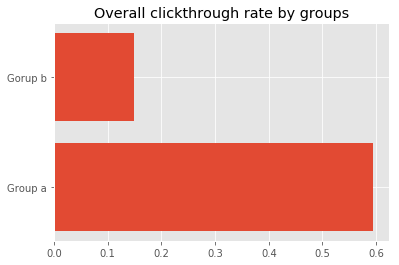

In [39]:
plt.barh(range(2),[.594,.1491])
plt.yticks(range(2),['Group a','Gorup b'])
plt.title('Overall clickthrough rate by groups')
plt.show()

## Which result position do people tend to try first? How does it change day-to-day?


## What is their daily overall zero results rate? How does it vary between the groups?


In [33]:
zerosessionids = data[(data.action == 'searchResultPage') & (data.n_results.isnull())].session_id.values
Zeroresult = data[data.session_id.isin(zerosessionids)]


In [29]:
print("zero results rate :", len(Zeroresult)/len(data))

zero results rate : 0.0


There are no search having results zero.

## Let session length be approximately the time between the first event and the last event in a session. Choose a variable from the dataset and describe its relationship to session length. Visualize the relationship.


In [52]:
a = data.timestamp[1] - data.timestamp[2]

In [58]:
a.seconds/60

81.0

In [95]:
A = clickthroughdata[clickthroughdata.group == 'a']
B = clickthroughdata[clickthroughdata.group == 'b']

group_A = A.groupby(['session_id'])['timestamp']
group_B = B.groupby(['session_id'])['timestamp']

In [102]:
start_A = group_A.min() #minimum time for a session id would be the time for first event
end_A = group_A.max() #maximum time for a session id would be the time for last event

start_B = group_B.min() #minimum time for a session id would be the time for first event
end_B = group_B.max() #maximum time for a session id would be the time for last event


In [103]:
(end_A - start_A).mean(),(end_B - start_B).mean()

(Timedelta('0 days 00:00:02.501359'), Timedelta('0 days 00:00:00.512262'))

The timestamp given in the dataset is weird as there is hardly any gap between the first event and last event for each session id.

In [109]:
print("time at first event: ",min(clickthroughdata[clickthroughdata.session_id == 'fff5341be7e1b6cf'].timestamp)) 
print("time at last event: ",max(clickthroughdata[clickthroughdata.session_id == 'fff5341be7e1b6cf'].timestamp)) 
print("max time of checkin: ",max(clickthroughdata[clickthroughdata.session_id == 'fff5341be7e1b6cf'].checkin)) 

## Didn't understood why check in time is that high when the gap between first event and last event is only 2 sec.

time at first event:  2608-11-08 20:28:22
time at last event:  2608-11-08 20:28:24
max time of checkin:  420.0


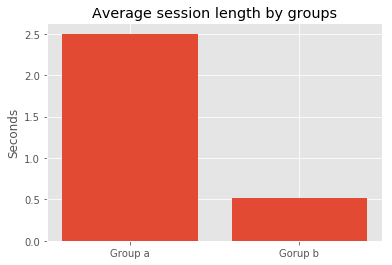

In [113]:
plt.bar(range(2),[2.501359,.512262])
plt.xticks(range(2),['Group a','Gorup b'])
plt.ylabel("Seconds")
plt.title('Average session length by groups')
plt.show()

In [115]:
len(A) , len(B)

(298908, 100547)